![Header Image](../assets/header_image.png "Header Image")

# Assignment 2: Boosting Semantic Image Segmentation

Welcome to the assignment __boosting semantic image segmentation__. In this assignment we will use __data augmentation__ for __semantic image segmentation__. 

As you may know, labled data for machine learning is very expensive to obtain. The KITTI dataset that we used in the previous assignment and also in this assignment consists of about 200 samples. This dataset size is quite small compared to other publicy available datasets, such as __Cityscapes__ or __Mapillary__. In this assignment we will use augmentation techniques to artificially increase the size of the train  dataset. In the following image you can see the exact same image-label pair, but each sample is slightly augmented.

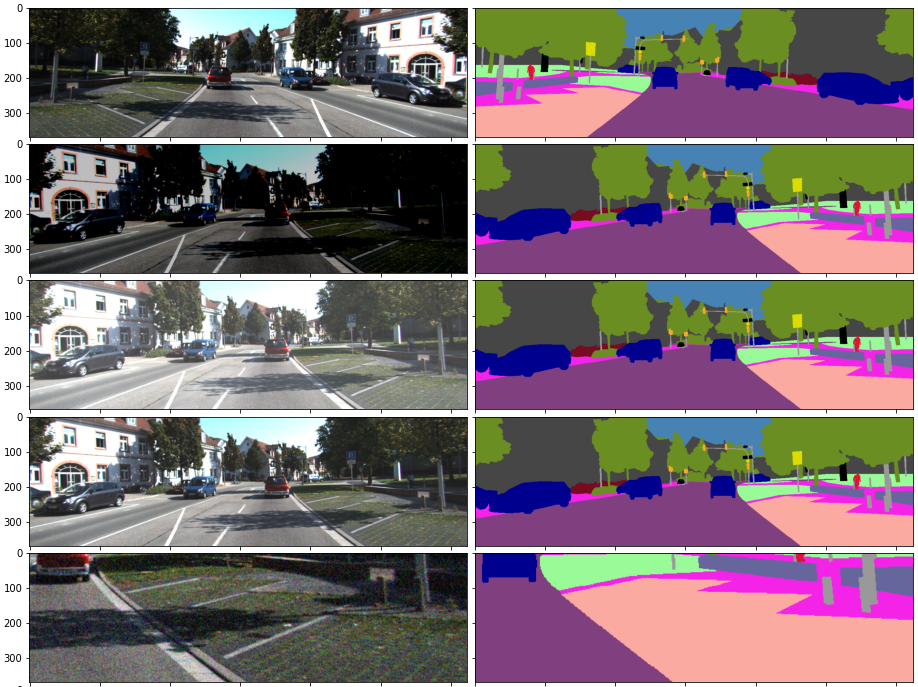

This data augmentation allows us to artificially increase the dataset size. We can the use these sample to train the segmentation model and improve the performance. Without annotating more images.

In this assignment we will walk through following steps:

- Implement several simple augmentation methods for semantic image segmentation
- Implement an augmentation policy method
- Integrate the augmentation policy into the dataset pipeline
- Compare two models. One trained on the original dataset and other trained on the augmented dataset

Let's start by importing all the necessary imports for this assignment:

In [3]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import glob
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

from segmentation_utils.metrics import SparseMeanIoU

random.seed(123)
tf.random.set_seed(42)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

# Dataset

Similar to the previous assignment, we will use the [KITTI Segmentation Dataset](http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015) which consists of 200 manually annotated images. The RGB camera images are located in the directory `datasets/kitti/image_2` and the corresponding labels are stored in directory `datasets/kitti/semantic_rgb`.

In [6]:
images_path_train = "datasets/kitti/image_2"
labels_path_train = "datasets/kitti/semantic_rgb"

# get file pathes
images_path_train = sorted(glob.glob(os.path.join(images_path_train, "*.png")))
labels_path_train = sorted(glob.glob(os.path.join(labels_path_train, "*.png")))

# shuffle the dataset
fused_list = list(zip(images_path_train, labels_path_train))
random.shuffle(fused_list)
images_path_train, labels_path_train = map(list, zip(*fused_list))

### Import of helper functions

In the previous assignment you have implemented the following functions:

- `parse_sample(image_path, label_path)`
- `convert_rgb_encoding_to_segmentation_map(image, rgb_to_class_id)`
- `segmentation_map_to_rgb_encoding(segmentation_map, rgb_to_class_id)`

For convienience we will just import the corretly implemented functions from `image_segmentation_utils.py`. We will also import the class-color association dict:

- `rgb_to_class_id`

In [7]:
from segmentation_utils.image_segmentation_utils import *

## Dataset inspection
We will just have a peak on the first sample of the dataset. This sample is used to implement and test several augmentation methods.

In [8]:
image, label = parse_sample(images_path_train[0], labels_path_train[0])

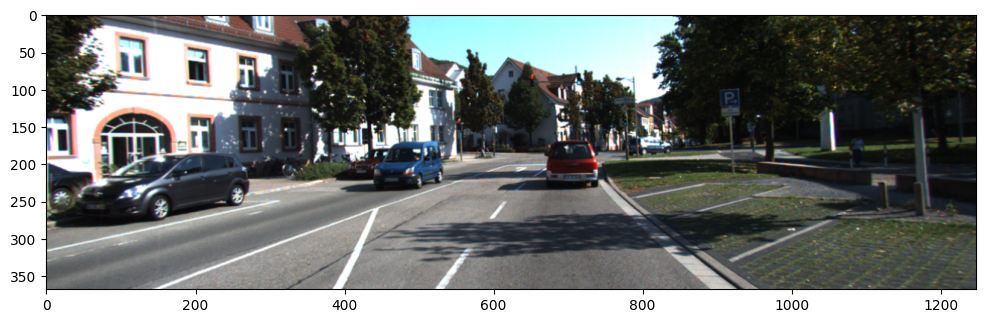

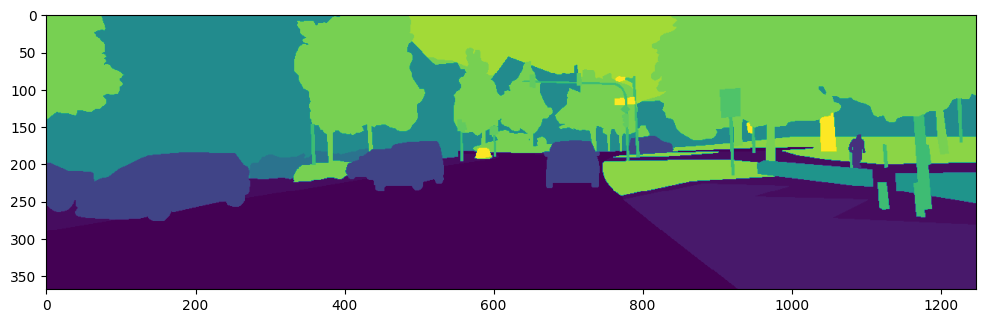

In [9]:
plt.imshow(image)
plt.show()

plt.imshow(label)
plt.show()

## Task: Implement Random Flip

Implement a randomized flip where the image-label pair is flipped with probability `0.5`. The augmentation method should increase the robustness of the model regarding the locaiton of objects in the scene.

#### Replace the `None` placeholders in the function `random_flip`

### Hints

- Read the documentation of function [tf.cond()](https://www.tensorflow.org/api_docs/python/tf/cond)
- Set up the condition `pred` by checking if `random` is bigger than `0.5`
- When the condition is true, the `true_fn` should flip image and label with function [tf.image.flip_left_right()](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right). Note that you have to apply `tf.image.flip_left_right()` twice on `image` and `label`.
- When the condition is false, the `false_fn` should just pass the image-label pair as `(image, label)` without modification

In [14]:
def random_flip(image, label):
    """
    Randomly flips the image-label pair along the 1-dimension with probability 0.5.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- Augmented tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    # creates a random float between 0 and 1
    random = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float16)
    condition = random > 0.5 
    (image, label) = tf.cond(
                             pred=condition,
                             true_fn=lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                             false_fn=lambda: (image, label)
                             )
    return image, label

### Test: `random_flip`

In the following, we will execute `random_flip` several times and we will plot the result with matplotlib

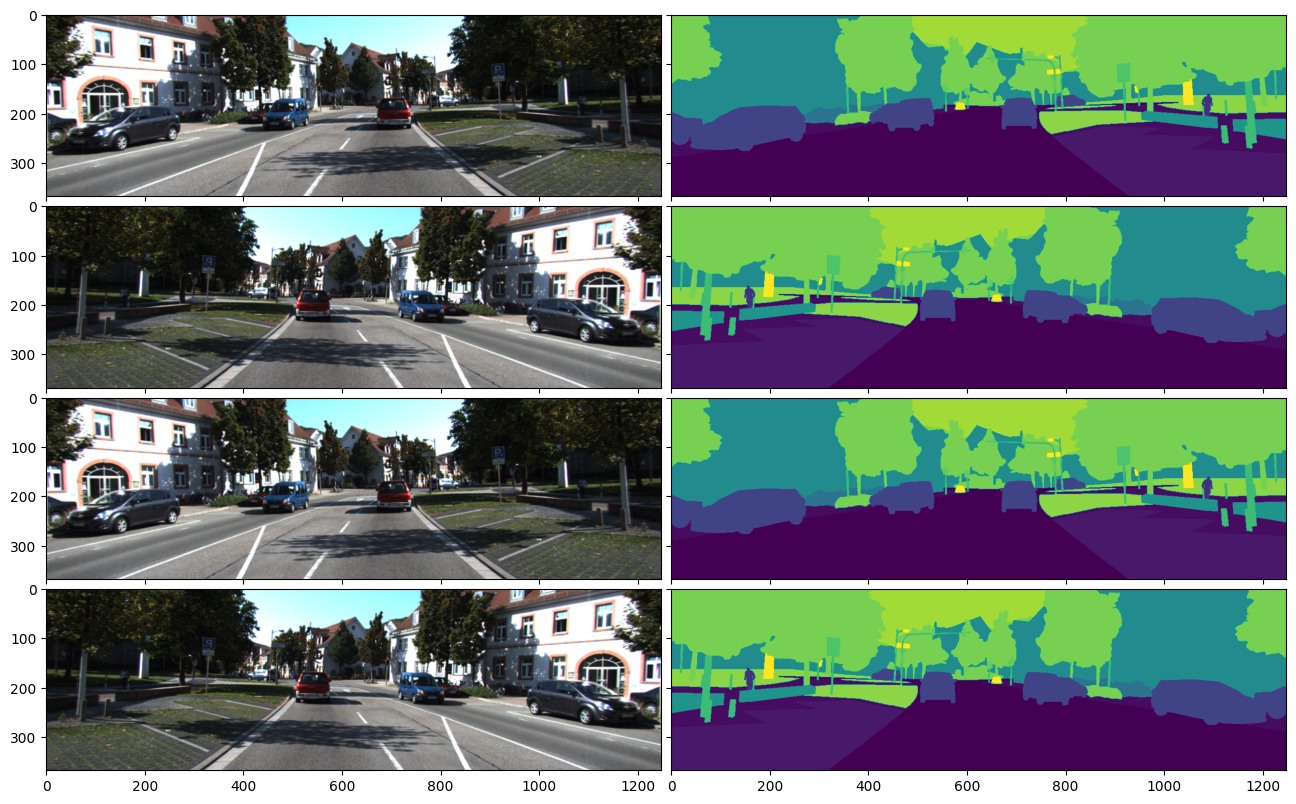

In [15]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for i in range(0, 4*2, 2):
    image_augmented, label_augmented = random_flip(image, label)
    
    grid[i].imshow(image_augmented)
    grid[i+1].imshow(label_augmented)

You should see that some image-label pairs are flipped horizontally. Execute the above cell block several times and you will see that the input is flipped randomly.

## Task: Implement Random Gamma
The illumination conditions can change quite drastically over the course of a day or due to shadows caused by buildings, trees or bridges. To simulate different illumination conditions we use a random gamma correction for image.

#### Replace the `None` placeholders in the function `random_gamma`


### Hints
- Create a random value `random_gamma` using function [tf.random.uniform()](https://www.tensorflow.org/api_docs/python/tf/random/uniform). The shape of that random variable should be `shape=[]`, the minimum should be `minval=0.3` and maximum should be `maxval=1.2`. The data type should be `dtype=tf.float32`.
- Apply the function [tf.image.adjust_gamma()](https://www.tensorflow.org/api_docs/python/tf/image/adjust_gamma) to the input image. Use the random variable `random_gamma` as parameter `gamma`.

In [ ]:
def random_gamma(image, label):
    """
    Randomly applies gamma augmentation to the image. The label should not be changed.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    
    random_gamma = tf.random.uniform(shape=[], minval=0.3, maxval=1.2, dtype=tf.float32)
    image = tf.image.adjust_gamma(image, random_gamma)  

    return image, label 

### Test: `random_gamma`

In the following we will execute `random_gamma` several times and we will plot the result with matplotlib.

In [ ]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for ax in grid:
    image_augmented, label_augmented = random_gamma(image, label)
    ax.imshow(image_augmented)

You should see that the input image is augmented with different gamma corrections.

## Task: Random Brightness
The brightness correction is quite similar to the gamma correction. The principle is the same, but this augmentation functions is implemented in a different way than the gamma correction. To ensure diversity in the augmentation methods, we will also use this random brightness function.

#### Replace the `None` placeholders in the function `random_brightness`


### Hints
- Simply use the function [tf.image.random_brightness()](https://www.tensorflow.org/api_docs/python/tf/image/random_brightness)  and apply it on `image`
- Use a `max_delta` of `0.4`

In [ ]:
def random_brightness(image, label):
    """
    Randomly applies brightness augmentation to the image. The label should not be changed.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    ### START CODE HERE ###
    image = None
    ### END CODE HERE ###
    return image, label

### Test: `random_brightness`

In the following we will execute `random_brightness` several times and we will plot the result with matplotlib.

In [ ]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for ax in grid:
    image_augmented, label_augmented = random_brightness(image, label)
    ax.imshow(image_augmented)

You should see several augmented instances of the input image.

## Task: Random Contrast
Another popular augmentation method is random contrast. In analogy to `random_brightness` we can just use the build-in function [tf.image.random_contrast()](https://www.tensorflow.org/api_docs/python/tf/image/random_contrast).

#### Replace the `None` placeholders in the function `random_contrast`


### Hints
- Simply use the function [tf.image.random_contrast()](https://www.tensorflow.org/api_docs/python/tf/image/random_contrast)  and apply it on `image`
- Use a `lower` of `0.2` and a `upper` of `1.1`

In [ ]:
def random_contrast(image, label):
    """
    Randomly applies contrast augmentation to the image. The label should not be changed.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    ### START CODE HERE ###
    image = None
    ### END CODE HERE ###
    return image, label

### Test: `random_contrast`

In the following we will execute `random_contrast` several times and we will plot the result with matplotlib.

In [ ]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for ax in grid:
    image_augmented, label_augmented = random_contrast(image, label)
    ax.imshow(image_augmented)

## Task: Random Noise
Another augmentation method is random noise. This augmentaion method simply adds gaussian noise to the input image. The idea is that slight noise in the input image increases the robustness of the network.

#### Replace the `None` placeholders in the function `random_noise`


### Hints
- Create a noise tensor with values drawn from a normal distrubution. Use [tf.random.normal()](https://www.tensorflow.org/api_docs/python/tf/random/normal) and create a tensor with the exact same shape as the input image. You can use [tf.shape()](https://www.tensorflow.org/api_docs/python/tf/shape) to retrieve the shape of the image.
- Use a mean of `0` and assign the standart deviation `stddev` to the random value `random_stddev`
- The noise should have a `dtype` of `tf.float32`
- Add the noise to the input image. Note that the noise is of type `tf.float32` and the image of type `tf.uint8`. You will need to cast the image to `tf.float32` before the addition. Use [tf.cast()](https://www.tensorflow.org/api_docs/python/tf/cast?hl=de).
- During that addition, it is possible that the image contains values larger than `255` or smaller than `0`. Therefore it is necessary to clip the image into range `[0.0, 255.0]`. Use [tf.clip_by_value](https://www.tensorflow.org/api_docs/python/tf/clip_by_value) to clip the image back to it's original range.
- Cast the image back to `tf.uint8`. Use [tf.cast()](https://www.tensorflow.org/api_docs/python/tf/cast?hl=de).

In [ ]:
def random_noise(image, label):
    """
    Randomly applies contrast augmentation to the image. The label should not be changed.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    
    # Create a random standart deviation - simulates the intensity of the noise
    random_stddev = tf.random.uniform(shape=[], minval=2, maxval=30, dtype=tf.float32)
    
    ### START CODE HERE ###
    # Create a noise tensor with a shape like the input image. Use zero-mean and a random std
    noise = tf.random.normal(None, mean=None, stddev=None, dtype=None)
    
    # Add the noise to the image. Cast the image to tf.float32 before the addition
    image = None + None
    
    # Clip the values of the image to [0, 255] 
    image = None
    
    # Cast the image back to tf.uint8
    image = None
    ### END CODE HERE ###
    
    return image, label

### Test: `random_noise`

In the following we will execute `random_noise` several times and we will plot the result with matplotlib.

In [ ]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for ax in grid:
    image_augmented, label_augmented = random_noise(image, label)
    ax.imshow(image_augmented)

The plot should now show some input images with some slight Gaussian noise.

## Task: Random Zoom
Another augmentation method is random zoom. That means we will randomly increase the size of the image-label pair and then perform a random crop to bring it back to the original image size. The idea of this augmentation method is to make the network learn features that are invariant against different scalings.

In this task you will have to read and understand the exisiting code and only complete the last to operations of this fuction. 

#### Replace the `None` placeholders in the function `random_zoom`


### Hints
- Read the documentation of [tf.image.crop_to_bounding_box()](https://www.tensorflow.org/api_docs/python/tf/image/crop_to_bounding_box) 
- Perform the exact same crop for the image and the label
- Param `image` will be the variable `image` and `label`
- `offset_height` corresponds to the vertical top-left corner coordinate `y_top_left`
- `offset_width` corresponds to the horizontal top-left corner coordinate `x_top_left`
- `target_height` should set according to the image's original shape. Use variable `original_shape` and take the first element `[0]` to retrieve the height
- `target_width` should set according to the image's original shape. Use variable `original_shape` and take the second element `[1]` to retrieve the width

In [ ]:
def random_zoom(image, label):
    """
    Randomly applies random zoom augmentation to the image-label pair. Randomly resizes the image 
    and then crops it back to original size.
    
    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    
    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- Augmented tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    # Store the original height, width of the input image
    original_shape = tf.shape(image)[:2]
    
    # Create a random scale between 1 und 2.5
    scale = tf.random.uniform(shape=[], minval=1, maxval=2.5, dtype=tf.float32)
    
    # Calculate the new dimension after scaling the the original image with scale
    new_dim = tf.cast(tf.cast([image.shape[0], image.shape[1]], tf.float32)*scale, tf.int32)
    
    # Resize the image to the new dimension  
    image = tf.image.resize(image, new_dim, method=tf.image.ResizeMethod.BILINEAR)
    label = tf.image.resize(label, new_dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # Resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image = tf.cast(image, tf.uint8)  
    
    # Calculate the positions boundaries of the top left corner of the new crop
    min_top_left = tf.constant([0, 0], dtype=tf.int32)
    max_top_left = new_dim - original_shape
    
    # Generate a random position of the new crop
    x_top_left, y_top_left = min_top_left[1], min_top_left[0]
    if min_top_left[1] < max_top_left[1]:
        x_top_left = tf.random.uniform(shape=[], minval=min_top_left[1], maxval=max_top_left[1], dtype=tf.int32)
    if min_top_left[0] < max_top_left[0]:
        y_top_left = tf.random.uniform(shape=[], minval=min_top_left[0], maxval=max_top_left[0], dtype=tf.int32)
    
    ### START CODE HERE ###
    # Crop the original image using the original shape and the new random position
    image = tf.image.crop_to_bounding_box(
        image=None,
        offset_height=None,
        offset_width=None,
        target_height=None,
        target_width=None
    )
    # Crop the original label using the original shape and the new random position
    label = tf.image.crop_to_bounding_box(
        image=None,
        offset_height=None,
        offset_width=None,
        target_height=None,
        target_width=None
    )
    ### END CODE HERE ###
    
    return image, label

### Test: `random_zoom`

In the following we will execute `random_zoom` several times and we will plot the result with matplotlib.

In [ ]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for i in range(0, 4*2, 2):
    image_augmented, label_augmented = random_zoom(image, label)
        
    grid[i].imshow(image_augmented)
    grid[i+1].imshow(label_augmented)

The plot should now show some input-label pairs where each sample has a different random crop/zoom.

# Augmentation Policy

Congratulations! You have now successfully implemented several augmentation methods! We will now integrate these augmentation functions into the training pipeline. There are many ways how to apply the augmentation methods. We can apply them in sequence, by random or we can use a augmantation policy as shown in relevant [literature](https://research.google/pubs/pub47890/).

An augmentation policy consists of a set of subpolicies where each subpolicies in turn consists of several operations in squence. Each operation can be associated with a probability. In the following you can see such a augmentation policy:

In [ ]:
AUGMENTATION_POLICY = {
    "subpolicy0": [(random_contrast, 0.75),   (random_zoom, 0.75)],
    "subpolicy1": [(random_gamma, 0.75),      (random_zoom, 0.75)],
    "subpolicy2": [(random_noise, 0.75),      (random_zoom, 0.75)],
    "subpolicy3": [(random_brightness, 0.75), (random_zoom, 0.75)],
    "subpolicy4": [(random_gamma, 0.75),      (random_zoom, 0.00)],
    "subpolicy5": [(random_brightness, 0.75), (random_zoom, 0.00)],
}

For example, if `subpolicy0` is chosen, then we will apply at first `random_contrast` with probability `0.75`. Then we would apply `random_zoom` with probability `0.75` on the same image. Both operations are performed in squence. Such a randomized approach ensures a high diversity in the training examples which in turn leads to a better model performance.

## Task: Apply Augmentation Policy

In this task you will have to implement a function that applies a __subpolicy__ to a training sample.


#### Replace the `None` placeholders in function `apply_augmentation_subpolicy`

### Hints
- Access the augmentation function and store it as `func`
- Access the probability and store it as `prob`
- Create a random float with [tf.random.uniform()](https://www.tensorflow.org/api_docs/python/tf/random/uniform). The value should be between `0` and `1`. Use a shape of `[]`
- Compare the random float with `prob`. If `random_float` is smaller or equal than `prob`, then apply `func` to the image label pair `(image, label)`. If false then use the image label without augmentation


In [ ]:
def apply_augmentation_subpolicy(image, label, subpolicy):
    """
    Applies a subpolicy to an input image and label. Return the augmented image and label.
    
    Arguments:
    - image -- tf.Tensor with shape [height, width, 3] representing the camera image 
    - label -- tf.Tensor with shape [height, width] representing the label
    - subpolicy -- List that contains several tuples of (augmentation_fuc, probability)
                  where probability is in [0, 1]. Each tuple is called operation. The probability 
                  determines the probability to apply the operation.
    
    Returns:
    - image -- Augmented tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- Augmented tf.Tensor with shape [height, width] representing the label
    """
    
    for operation in subpolicy:
        ### START CODE HERE ###
        
        # get the augmentation function from operation, remember that the function is the first element of an operation
        func = None
        
        # get the probability from operation, remember that the probability is the second element of an operation
        prob = None

        # pull a random float from a uniform distribution from [0, 1]
        random_float = None
        
        # apply func to (image, label) only when random_float <= prob 
        image, label = tf.cond(
            pred=None,
            true_fn=lambda: None,
            false_fn=lambda: None
            )
        
        ### END CODE HERE ###
    return image, label

### Test `apply_augmentation_subpolicy`

In [ ]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for i in range(0, 4*2, 2):
    image_augmented, label_augmented = apply_augmentation_subpolicy(image, label, AUGMENTATION_POLICY["subpolicy1"])
        
    grid[i].imshow(image_augmented)
    grid[i+1].imshow(label_augmented)

The plot should now show some input-label pairs where each sample has a different random crop/zoom and also a random gamma correction.

## Task: Apply Augmentation Policy

In the previous task, we applied a single subpolicy to the input image-label pair. Now we will apply the whole augmentation policy to the input. In each call, we will take a random subpolicy and apply it to the image.

#### Replace the `None` placeholders in function `apply_augmentation_policy`

### Hints
- Apply `random_flip` before any other augmentation function
- Get the number of subpolicies by using `len()` and store it in `num_policies`
- Create a random integer with [tf.random.uniform](https://www.tensorflow.org/api_docs/python/tf/random/uniform) between `0` and `num_policies` . Use a shape of `[]` and `dtype=tf.int32`
- This random integer represents the subpolicy that we will use from `policy`
- Iterate over the policies and compare `random_policy` and `idx` with [`tf.equal(random_policy, idx)`](https://www.tensorflow.org/api_docs/python/tf/math/equal).
    - If they are equal, apply `apply_augmentation_subpolicy` on the image label pair.
        - First parameter of `apply_augmentation_subpolicy` should be `image`
        - Second parameter of `apply_augmentation_subpolicy` should be `label`
        - Third parameter of `apply_augmentation_subpolicy` should be the policy. Use `idx` get the correct policy: `policy["subpolicy"+str(idx)]`
    - If `random_policy` and `idx` are not the same, don't apply any augmentation function to image-label and return `(image, label)`

In [ ]:
def apply_augmentation_policy(image, label, policy):
    """
    Applies a policy to a input image and label. Returns the augmented image and label.
    
    Arguments:
    - image -- tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- tf.Tensor with shape [height, width] representing the label
    - policy -- Dictionary which contains subpolicies. Each element in the dictionary has
                the key `subpolicyX` where X represents the index starting from 0.
    
    Returns:
    - image -- Augmented tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- Augmented tf.Tensor with shape [height, width] representing the label
    """
    ### START CODE HERE ###
    
    # always radnom flip the image before any other augmentation
    image, label = None
    
    # get the number of subpolicies
    num_policies = None
    
    # create a random integer in [0, num_policies)
    random_policy = None

    # take all policies and choose random policy based on idx
    for idx in range(num_policies):
        image, label = tf.cond(
                    pred=None,
                    true_fn=lambda: apply_augmentation_subpolicy(None, None, None),
                    false_fn=lambda: None
                    )
    ### END CODE HERE ###
    
    return image, label

In [ ]:
fig = plt.figure(figsize=(40, 40))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(16, 2),
                 axes_pad=0.1,
                 )

for i in range(0, 16*2, 2):
    image_augmented, label_augmented = apply_augmentation_policy(image, label, AUGMENTATION_POLICY)
    label_augmented = segmentation_map_to_rgb_encoding(tf.squeeze(label_augmented), rgb_to_class_id)
    
    grid[i].imshow(image_augmented)
    grid[i+1].imshow(label_augmented)

The plot should now show some input-label pairs where each sample is randomly augmented.

## Augmentation wrapper function

Good job! You created you own augmentation function for semantic image segmentation. Feel free to change the values or structure in `AUGMENTATION_POLICY` in order to obtain different augmentation results. You could add more subpolicies or use more opartations in each subpolicy. We will now create wrapper function around `apply_augmentation_policy` to make it useable with the [tf.data API](https://www.tensorflow.org/guide/data).

In [ ]:
def augmentation_wrapper(image, label):
    image, label = apply_augmentation_policy(image, label, AUGMENTATION_POLICY) 
    return image, label

We will also quickly define the input normlization function.

In [ ]:
def normalize(image, label):
    return tf.cast(image, tf.float32)/255.0, label

## Task: Dataset creation with augmentation
From the previous assignment you have learned how to use the [tf.data API](https://www.tensorflow.org/guide/data)  to build efficient data pipelines for our training. Now, we want to use our augmentation function and augmentation policy and integrate it into our input pipeline.


- Use `map` class function along with the function `augmentation_wrapper` to apply the augmentation to the dataset pipeline. Use again `tf.data.AUTOTUNE` for `num_parallel_calls`.
- Only apply the augmentation if param `do_augmentation` is True

In [ ]:
def create_dataset(images_path, labels_path, batch_size=4, buffer_size=200, do_augmentation=False):
    """
    Dataset creation function. Creates a input pipeline for semantic image segmentation.
    
    Arguments:
    - images_path -- List of Strings which contain pathes for the camera images
    - labels_path -- List of Strings which contain pathes for the label images
    - batch_size -- Integer - Size of the batches during data creation
    - buffer_size -- Integer - Size of the buffer for shuffeling
    - do_augmentation -- Boolean - If True, apply data augmentation
    
    Returns:
    - dataset -- tf.data.Dataset
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path))
    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size=buffer_size)
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)
    
    ### START CODE HERE ### 
    # Apply augmentation policy
    if None:
        dataset = None
    ### END CODE HERE ###
    
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size=batch_size)
    # Use prefetching 
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

## Dataset creation


Similar to the previous example, we will use a train size of `70 %` and a validation size of `30 %`

In [ ]:
train_size = round(len(images_path_train)*0.7)

### Task: Create `train` and `val` datasets


- Use the function `create_dataset`
- Use index slicing to select `70%` of the data for training and `30%` for validation
- Use `do_augmentation=True` for the training split 
- Use `do_augmentation=False` for the validation split

In [ ]:
### START CODE HERE ### 

# Create the train dataset
train = None

# Create the validation dataset
val = None

### END CODE HERE ###

### Test: Create `train` and `val` datasets

In [ ]:
print("Train Dataset Length:", tf.data.experimental.cardinality(train).numpy())
print("Val Dataset Length:", tf.data.experimental.cardinality(val).numpy())

### Expected Output

# Model training

Similar to the previous assignment we will load the U-Net segmentation model and compile it with the same params as before. Because you have already complete the construction of the model in the previous assignment we will simply call `getModel` to obtain the segmentation model.

In [ ]:
model = getModel(input_shape=[368, 1248, 3], num_classes=30)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=[SparseMeanIoU(num_classes=30, name="MIoU")])

Now, the training of the model can be evoked by calling the class function `fit`. Note that we will train here only 1 epoch for demonstration. We don't want you to wait several hours for the model to finish. We will use in the next steps a pretrained model which was trained for several hundred steps using the augmented data pipeline.

In [ ]:
history = model.fit(train, validation_data=val, epochs=1, verbose=1)

### Expected Output
You can expect an output similar to the following

# Model Comparison

Now, we want to compare the accuracy of the segmentation models. We have now one model trained like in the previous assignment without any augmentation methods. And we have also a second model trained with our augmentation pipeline. Both models were trained for about 1000 epochs and with the same settings.

We will now evaluate the model that was trained __without augmentation__ by loading the weights into the graph.

In [ ]:
model.load_weights("segmentation_utils/pretrained_model/model")
result = model.evaluate(val)
print(result)

#### Expected Output
The `evaluate` class function returns us the following: 

That means we have a loss of `1.42` and a MIoU of `34 %` on the validation dataset.

Now, we evaluate the model that was trained __with the augmentation__ pipeline:

In [ ]:
model.load_weights("segmentation_utils/pretrained_model_with_augmentation/model")
result = model.evaluate(val)
print(result)

#### Expected Output
The `evaluate` class function returns us the following:

Hence, the model with augmentation training has a loss of `0.61` and a MIoU of `37 %` on the validation dataset. 

We can conclude that the model trained with the augmented samples has a better performance than the model without any data augmentation. We could increase the performance of the model without adding any additional training data.

# Model inference

We can now perform __inference__ on that model by loading a sample from the dataset and use the model's `predict` function.

In [ ]:
image, label = parse_sample(images_path_train[-1], labels_path_train[-1])
image = tf.expand_dims(image, axis=0)
probabilities = model.predict(tf.cast(image, tf.float32) / 255.0)

prediction = tf.argmax(probabilities, axis=-1)
prediction = tf.squeeze(prediction)

### Plot of the segmentation map
Now we can simply use matplotlib's `imshow` function to visualize the predictions and the label.

In [ ]:
plt.figure()
plt.imshow(prediction)
plt.title("Segmentation Map Prediction")
plt.show()

plt.figure()
plt.imshow(label)
plt.title("Segmentation Map Label")
plt.show()

In [ ]:
rgb_encoding = segmentation_map_to_rgb_encoding(prediction, rgb_to_class_id)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Prediction")
plt.show()

rgb_encoding = segmentation_map_to_rgb_encoding(np.squeeze(label), rgb_to_class_id)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Label")
plt.show()

### Expected Output

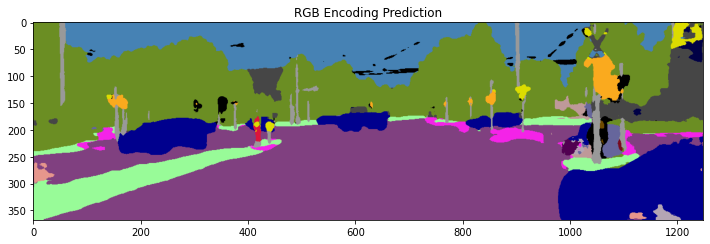

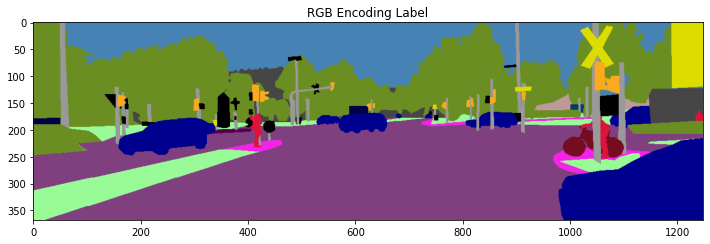

Gratulations! You finished the Assignment `Boosting Semantic Image Segmentation`

# Wrap Up
- You learned about data augmentation for semantic image segmentation
- You learned about augmentation policies
- You learned about the comparison of different deep learning models

# References

#### Kitti Dataset

U-Net Architecture

## License

MIT License

Copyright 2023 Institute for Automotive Engineering of RWTH Aachen University.